In [1]:
import arrow
import datetime
import gsw
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import os
import pandas as pd
import xarray as xr
import cmocean.cm as cm
import matplotlib.dates as mpl_dates
from salishsea_tools import viz_tools

In [2]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')

In [3]:
iY = 258; iX = 178; iZ = 28
depths = slice(0, iZ)
iY2 = 388; iX2 = 271
print (mesh.variables['gdepw_0'][0, iZ+1, iY2, iX2])
e3t = mesh.variables['e3t_0'][0, 0:iZ, iY, iX]
print(e3t.shape)

<xarray.Variable ()>
[1 values with dtype=float32]
Attributes:
    standard_name:  gdepw_0
    long_name:      depth of W-grid points
    units:          m
    positive:       down
(28,)


### Functions

In [4]:
def get_ts(start, endtime, numberofdays):
    timerange = arrow.Arrow.range('day', start, endtime)
    saltV = np.empty((numberofdays, iZ))
    tempV = np.empty_like(saltV)
    saltS = np.empty_like(saltV)
    tempS = np.empty_like(saltV)
    time = []
    for it, r in enumerate(timerange):
        dir1 = r.format('DDMMMYY').lower()
        ymd = r.format('YYYYMMDD')
        filename = f'SalishSea_1d_{ymd}_{ymd}_grid_T.nc'
        with xr.open_dataset(os.path.join('/results2/SalishSea/nowcast-green.202111/', dir1, filename)) as ds:
            saltV[it, :] = ds.vosaline[0, depths, iY, iX]
            saltS[it, :] = ds.vosaline[0, depths, iY2, iX2]
            tempV[it, :] = ds.votemper[0, depths, iY, iX]
            tempS[it, :] = ds.votemper[0, depths, iY2, iX2]
            time.append(r.datetime)
    return time, saltV, saltS, tempV, tempS

In [5]:
def find_mean_sigma(saltV, saltS, tempV, tempS):
    sigmaV = gsw.density.sigma0(saltV, tempV)

    tlen = sigmaV.shape[0]
    south = np.mean(sigmaV[0:tlen] * np.expand_dims(e3t,axis=0), axis=1) # depth averaging the density

    sigmaS = gsw.density.sigma0(saltS, tempS)
    tlen = sigmaS.shape[0]
    north = np.mean(sigmaS[0:tlen] * np.expand_dims(e3t,axis=0), axis=1) # depth averaging the density
    return south, north

### Density difference to each strait

### Plot locations on map

In [4]:
jan18_data = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01jun18/SalishSea_1d_20180601_20180601_grid_T.nc')
jan18_sal = jan18_data['vosaline'][0,1]

grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_202108.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask202108.nc')
tmask = 1 - mask.tmask[0]

cmap = cm.dense

# Mask NaN values in the data
masked_sal = np.ma.masked_array(jan18_sal, mask=tmask[0])

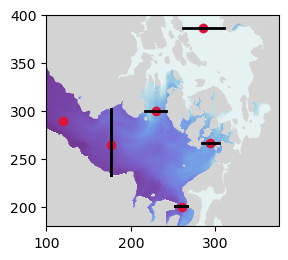

In [8]:
vs_y = np.arange(233,303,1)
vs_x = np.linspace(177,177,len(vs_y))
adm_x = np.arange(252,267,1)
adm_y = np.linspace(201,201,len(adm_x))
pr_x = np.arange(262,311,1)
pr_y = np.linspace(386,386,len(pr_x))
gulf_x = np.arange(216,251,1)
gulf_y = np.linspace(386,386,len(gulf_x))
ros_x = np.arange(284,305,1)
ros_y = np.linspace(267,267,len(ros_x))
sjc_x = np.arange(263,267,1)
sjc_y = np.linspace(280,280,len(sjc_x))
haro_x = np.arange(217,242,1)
haro_y = np.linspace(300,300,len(haro_x))


fig,ax1 = plt.subplots(1,1,figsize=(3, 4))

c = ax1.pcolormesh(masked_sal, cmap=cmap,vmin=25,vmax=34
)

subdomain = [100, 375, 180, 400]

for attr, color in zip(['contourf', 'contour'], ['lightgray', 'lightgrey']):
    getattr(ax1, attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) #If 0 -> contour f makes all that are 0 grey. contour makes the transition to 0 black

ax1.set_xlim(subdomain[:2])
ax1.set_ylim(subdomain[2:])
# [0]ax.set_xlabel('Grid X')
# [0]ax.set_ylabel('Grid Y')
viz_tools.set_aspect(ax1);

ax1.plot(vs_x,vs_y,color='k',lw=2)
ax1.plot(adm_x,adm_y,color='k',lw=2)
ax1.plot(vs_x,vs_y,color='k',lw=2)
ax1.plot(pr_x,pr_y,color='k',lw=2)
ax1.plot(adm_x,adm_y,color='k',lw=2)
ax1.plot(ros_x,ros_y,color='k',lw=2)
ax1.plot(haro_x,haro_y,color='k',lw=2)

ax1.scatter(260,200,color='crimson') # adm
ax1.scatter(285,386,color='crimson') # pr
ax1.scatter(177,265,color='crimson') # vs
ax1.scatter(230,300,color='crimson') # haro
ax1.scatter(293,267,color='crimson') # ros
ax1.scatter(120,290,color='crimson') # jdf

[]

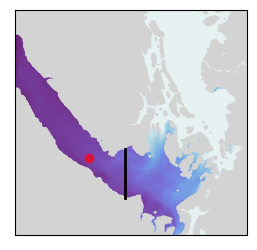

In [20]:
vs_y = np.arange(233,303,1)
vs_x = np.linspace(177,177,len(vs_y))
adm_x = np.arange(252,267,1)
adm_y = np.linspace(201,201,len(adm_x))
pr_x = np.arange(262,311,1)
pr_y = np.linspace(386,386,len(pr_x))
gulf_x = np.arange(216,251,1)
gulf_y = np.linspace(386,386,len(gulf_x))
ros_x = np.arange(284,305,1)
ros_y = np.linspace(267,267,len(ros_x))
sjc_x = np.arange(263,267,1)
sjc_y = np.linspace(280,280,len(sjc_x))
haro_x = np.arange(217,242,1)
haro_y = np.linspace(300,300,len(haro_x))


fig,ax1 = plt.subplots(1,1,figsize=(3, 4))

c = ax1.pcolormesh(masked_sal, cmap=cmap,vmin=25,vmax=34
)

subdomain = [0, 375, 180, 500]

for attr, color in zip(['contourf', 'contour'], ['lightgray', 'lightgrey']):
    getattr(ax1, attr)(mesh.tmask[0, 0, ...],levels=[-0.01,0.01], colors=color) #If 0 -> contour f makes all that are 0 grey. contour makes the transition to 0 black

ax1.set_xlim(subdomain[:2])
ax1.set_ylim(subdomain[2:])
# [0]ax.set_xlabel('Grid X')
# [0]ax.set_ylabel('Grid Y')
viz_tools.set_aspect(ax1);

ax1.plot(vs_x,vs_y,color='k',lw=2)
# ax1.plot(adm_x,adm_y,color='k',lw=2)
# ax1.plot(vs_x,vs_y,color='k',lw=2)
# ax1.plot(pr_x,pr_y,color='k',lw=2)
# ax1.plot(adm_x,adm_y,color='k',lw=2)
# ax1.plot(ros_x,ros_y,color='k',lw=2)
# ax1.plot(haro_x,haro_y,color='k',lw=2)

# ax1.scatter(260,200,color='crimson') # adm
# ax1.scatter(285,386,color='crimson') # pr
# ax1.scatter(177,265,color='crimson') # vs
# ax1.scatter(230,300,color='crimson') # haro
# ax1.scatter(293,267,color='crimson') # ros
ax1.scatter(120,290,color='crimson') # jdf

ax1.set_xticks([])
ax1.set_yticks([])

In [21]:
fig.savefig('/ocean/cstang/MOAD/analysis-camryn/Figures/jdf_dens_loc.png',bbox_inches='tight')

<xarray.Variable ()>
[1 values with dtype=float32]
Attributes:
    standard_name:  gdepw_0
    long_name:      depth of W-grid points
    units:          m
    positive:       down
(24,)


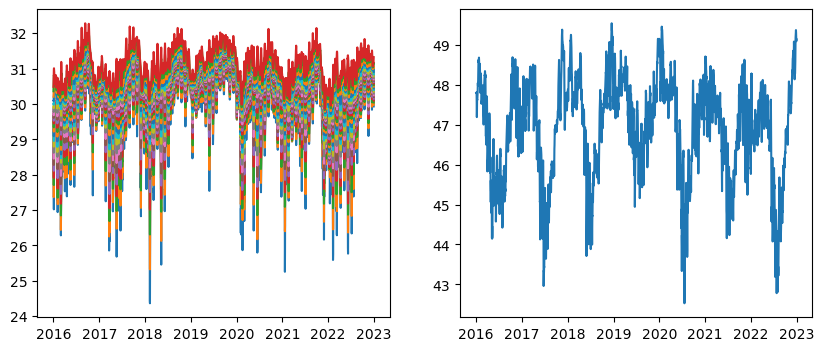

In [23]:
# Density difference for Admiralty / point rob

iY = 386; iX = 285; iZ = 24 #point rob
depths = slice(0, iZ)
iY2 = 200; iX2 = 260 #admiralty
print (mesh.variables['gdepw_0'][0, iZ+1, iY2, iX2])
e3t = mesh.variables['e3t_0'][0, 0:iZ, iY, iX]
print(e3t.shape)

start = datetime.datetime(2016, 1, 1)
endtime = datetime.datetime(2022, 12, 31)
numberofdays = int((endtime - start)/(datetime.datetime(2015, 1, 2) - datetime.datetime(2015, 1, 1)) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
time, saltV, saltS, tempV, tempS = get_ts(start, endtime, numberofdays)
ax[0].plot(time, saltS); # Plots 1 line for each depth at north section
south, north = find_mean_sigma(saltV, saltS, tempV, tempS) #Average of all depths for south and north
ax[1].plot(time, south)

density = pd.DataFrame(data={'south': south, 'north': north}, index=time)
density.to_csv('sigma_admpr_v3.csv')

<xarray.Variable ()>
[1 values with dtype=float32]
Attributes:
    standard_name:  gdepw_0
    long_name:      depth of W-grid points
    units:          m
    positive:       down
(24,)


KeyboardInterrupt: 

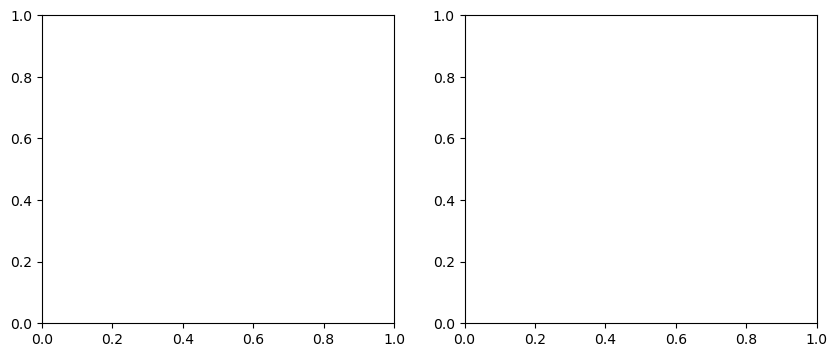

In [31]:
# Density difference for rosario / point rob

iY = 386; iX = 285; iZ = 24 #point rob
depths = slice(0, iZ)
iY2 = 267; iX2 = 293 #ros
print (mesh.variables['gdepw_0'][0, iZ+1, iY2, iX2])
e3t = mesh.variables['e3t_0'][0, 0:iZ, iY, iX]
print(e3t.shape)

start = datetime.datetime(2016, 1, 1)
endtime = datetime.datetime(2022, 12, 31)
numberofdays = int((endtime - start)/(datetime.datetime(2015, 1, 2) - datetime.datetime(2015, 1, 1)) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
time, saltV, saltS, tempV, tempS = get_ts(start, endtime, numberofdays)
ax[0].plot(time, saltS); # Plots 1 line for each depth at north section
south, north = find_mean_sigma(saltV, saltS, tempV, tempS) #Average of all depths for south and north
ax[1].plot(time, south)

density = pd.DataFrame(data={'south': south, 'north': north}, index=time)
density.to_csv('sigma_rospr.csv')

<xarray.Variable ()>
[1 values with dtype=float32]
Attributes:
    standard_name:  gdepw_0
    long_name:      depth of W-grid points
    units:          m
    positive:       down
(24,)


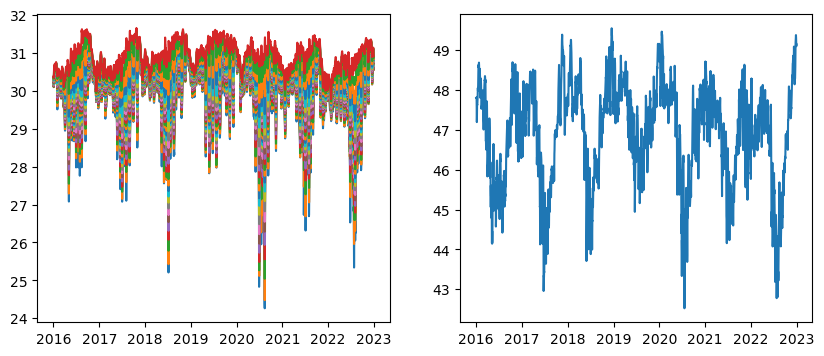

In [32]:
# Density difference for haro / point rob

iY = 386; iX = 285; iZ = 24 #point rob
depths = slice(0, iZ)
iY2 = 300; iX2 = 230 #haro
print (mesh.variables['gdepw_0'][0, iZ+1, iY2, iX2])
e3t = mesh.variables['e3t_0'][0, 0:iZ, iY, iX]
print(e3t.shape)

start = datetime.datetime(2016, 1, 1)
endtime = datetime.datetime(2022, 12, 31)
numberofdays = int((endtime - start)/(datetime.datetime(2015, 1, 2) - datetime.datetime(2015, 1, 1)) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
time, saltV, saltS, tempV, tempS = get_ts(start, endtime, numberofdays)
ax[0].plot(time, saltS); # Plots 1 line for each depth at north section
south, north = find_mean_sigma(saltV, saltS, tempV, tempS) #Average of all depths for south and north
ax[1].plot(time, south)

density = pd.DataFrame(data={'south': south, 'north': north}, index=time)
density.to_csv('sigma_haropr.csv')

<xarray.Variable ()>
[1 values with dtype=float32]
Attributes:
    standard_name:  gdepw_0
    long_name:      depth of W-grid points
    units:          m
    positive:       down
(24,)


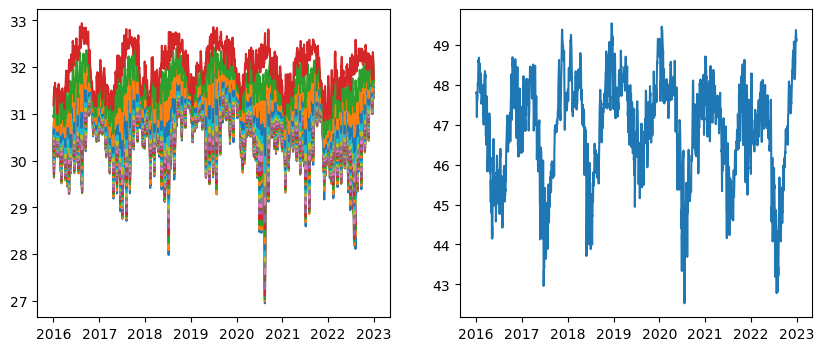

In [6]:
# Density difference for vs / point rob

iY = 386; iX = 285; iZ = 24 #point rob
depths = slice(0, iZ)
iY2 = 265; iX2 = 177 #vs
print (mesh.variables['gdepw_0'][0, iZ+1, iY2, iX2])
e3t = mesh.variables['e3t_0'][0, 0:iZ, iY, iX]
print(e3t.shape)

start = datetime.datetime(2016, 1, 1)
endtime = datetime.datetime(2022, 12, 31)
numberofdays = int((endtime - start)/(datetime.datetime(2015, 1, 2) - datetime.datetime(2015, 1, 1)) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
time, saltV, saltS, tempV, tempS = get_ts(start, endtime, numberofdays)
ax[0].plot(time, saltS); # Plots 1 line for each depth at north section
south, north = find_mean_sigma(saltV, saltS, tempV, tempS) #Average of all depths for south and north
ax[1].plot(time, south)

density = pd.DataFrame(data={'south': south, 'north': north}, index=time)
density.to_csv('sigma_vspr_v3.csv')

<xarray.Variable ()>
[1 values with dtype=float32]
Attributes:
    standard_name:  gdepw_0
    long_name:      depth of W-grid points
    units:          m
    positive:       down
(26,)


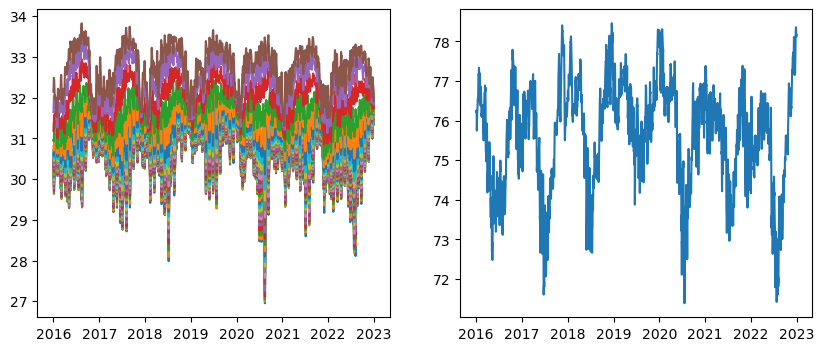

In [31]:
# Density difference for vs / point rob

iY = 386; iX = 285; iZ = 26 #point rob
depths = slice(0, iZ)
iY2 = 265; iX2 = 177 #vs
print (mesh.variables['gdepw_0'][0, iZ+1, iY2, iX2])
e3t = mesh.variables['e3t_0'][0, 0:iZ, iY, iX]
print(e3t.shape)

start = datetime.datetime(2016, 1, 1)
endtime = datetime.datetime(2022, 12, 31)
numberofdays = int((endtime - start)/(datetime.datetime(2015, 1, 2) - datetime.datetime(2015, 1, 1)) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
time, saltV, saltS, tempV, tempS = get_ts(start, endtime, numberofdays)
ax[0].plot(time, saltS); # Plots 1 line for each depth at north section
south, north = find_mean_sigma(saltV, saltS, tempV, tempS) #Average of all depths for south and north
ax[1].plot(time, south)

density = pd.DataFrame(data={'south': south, 'north': north}, index=time)
density.to_csv('sigma_vspr_v4.csv')

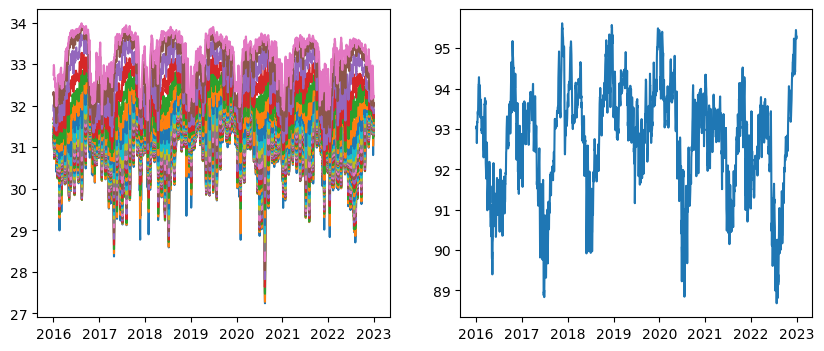

In [13]:
# Density difference for jdf / point rob

start = datetime.datetime(2016, 1, 1)
endtime = datetime.datetime(2022, 12, 31)
numberofdays = int((endtime - start)/(datetime.datetime(2015, 1, 2) - datetime.datetime(2015, 1, 1)) + 1)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
time, saltV, saltS, tempV, tempS = get_ts(start, endtime, numberofdays)
ax[0].plot(time, saltS); # Plots 1 line for each depth at north section
south, north = find_mean_sigma(saltV, saltS, tempV, tempS) #Average of all depths for south and north
ax[1].plot(time, south)

density = pd.DataFrame(data={'south': south, 'north': north}, index=time)
density.to_csv('sigma_jdfpr.csv')